
## Lab 4: Cat Dog Classification with Data Augmentation & CNNs


In [ ]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import sys
from glob import glob
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow import keras

## Part 1: Importing the dataset from Kaggle

Before we start, lets get some of the basic steps cleared: <br>
<h5> 1. Create a Kaggle account</h5>

- Create an account on Kaggle.com - this is mandatory, since we will be accessing the dataset from Kaggle directly in Google Colab.
- Next go to the link given : https://www.kaggle.com/c/dogs-vs-cats/data. This is the dataset we will be using for this lab. Go to teams and enter a team name(Random - this is not a Kaggle contest)

<h5> 2. Get the dataset to Google colab</h5>

- On your account on Kaggle - top right corner of the page [Profile , **Account**, Sign Out] - Click on account and scroll down to APIs. 
- Here create a new API token - you should get an option to download a **kaggle.json** file

In [ ]:
#Install kaggle
! pip install -q kaggle

In [ ]:
#Upload the kaggle.json file you just downloaded
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishalrishi","key":"388a983fe357b40edb0b58a7ed0f3889"}'}

In [ ]:
#Make directory named kaggle 
!mkdir ~/.kaggle

In [ ]:
# copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/

In [ ]:
#change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
# Download the dataset zip in this location 
DATA_DIR = '../data' 

In [ ]:
#downloading the dataset from Kaggle
!kaggle competitions download -c dogs-vs-cats -p {DATA_DIR}

 98% 533M/543M [00:11<00:00, 64.4MB/s]
100% 543M/543M [00:11<00:00, 48.4MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 28.9MB/s]
100% 271M/271M [00:07<00:00, 51.6MB/s]
100% 271M/271M [00:07<00:00, 35.7MB/s]


Unzip the file and delete the other unnecessary files and original zip.

In [ ]:
#Unzipping
shutil.unpack_archive(os.path.join(DATA_DIR,'train.zip'), DATA_DIR)
os.remove(os.path.join(DATA_DIR, 'train.zip')) 
# changing the data directory to KAGGLE_DIR
KAGGLE_DIR = os.path.join(DATA_DIR, 'dogs-vs-cats') 
shutil.move(os.path.join(DATA_DIR,'train'), KAGGLE_DIR) 

'../data/dogs-vs-cats'

The dogs and cats are all mixed in a single directory. The label is in the file name itself.</br>
We need to create:
1. Train, validation, and test directories, each containing a subset of the images.
2. Separate cat and dog directories _within_ train, validation, and test.

Number 2 is necessary because the Keras ImageDataGenerator's flow_from_directory() method infers the class label from the subdirectory the image resides in.

Therefore, we need to create a directory structure as seen below:


In [ ]:
# dogs_vs_cats
# ├── test
# │   ├── cats
# │   └── dogs
# ├── train
# |   ├── cats
# |   └── dogs
# └── validation
#     ├── cats
#     └── dogs

In [ ]:
# Create train, validation, and test directories
split_dirs = ['train', 'validation', 'test']
for split_dir in split_dirs:
    # create label subdirectories
    label_dirs = ['dogs', 'cats']
    for label_dir in label_dirs:
        new_dir = os.path.join(KAGGLE_DIR, split_dir, label_dir)
        os.makedirs(new_dir, exist_ok=True)

In [ ]:
# copy dataset images into subdirectories based on probability distribution 'p'
PERCENT_OF_DATA = 0.1
np.random.seed(42)
for file in os.listdir(KAGGLE_DIR):
    if not file.endswith('.jpg'):
        continue # skip over non-image files
    src = os.path.join(KAGGLE_DIR, file)
    if np.random.uniform() > PERCENT_OF_DATA:
        os.remove(src)
        continue
    dst_dir = np.random.choice(['train', 'validation', 'test'], p=[.5, .25, .25])
    if file.startswith('cat'):
        dst = os.path.join(KAGGLE_DIR, dst_dir, 'cats', file)
    elif file.startswith('dog'):
        dst = os.path.join(KAGGLE_DIR, dst_dir, 'dogs', file)
    try:
        shutil.move(src, dst)
    except Exception as e:
        print(e)

In [ ]:
#Number of images in each subdir
for dir_name in split_dirs:
    for label_dir in label_dirs:
        print(dir_name ,label_dir, len(os.listdir(KAGGLE_DIR + '/' + dir_name + '/' + label_dir)))

train dogs 579
train cats 665
validation dogs 308
validation cats 348
test dogs 310
test cats 342


In [ ]:
# Preprocessing the image into a 4D tensor
img_path = glob(KAGGLE_DIR+'/*/*/*.jpg')[0]

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


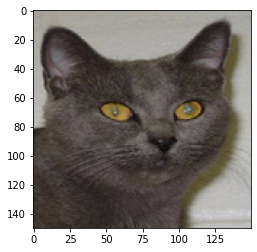

In [ ]:
# Displaying an example img
plt.imshow(img_tensor[0])
plt.show()

## Part 2: Creating the Generators and training a model with only rescaled images

<b>Create the Generators</b>

Now that we have the data in the correct directory structure we can create the data generators.
Yes, that's correct. We will have _multiple_ generators, one for each split directory.<br>


First we create a main data generator object, `datagen`. This can be a given a wide range of arguments which can be used to preprocess the images it generates.</br>

<b>For right now we will only use the `rescale` argument to normalize all pixel values to between 0 and 1 (remember that 255 is the max pixel value).</b>

In [ ]:
datagen = ImageDataGenerator(rescale=0.8)

Now we use `datagen`'s `flow_from_directory` method to create the 3 generators: `traingen`, `valgen`, and `testgen`.<br>

The function needs to be given the following parameters:<br>
- `directory` which they will use as their image source
- `target_size` to resize all images to (75,75)
- `batch_size`
- `class_mode` to instruct the generator on how to interpret the label folders. 

We should probably also set `shuffle = False` in the test generator so it produces the same images in the same order everytime it is used.

In [ ]:
batch_size = 16
target_size = (96,96)

traingen = datagen.flow_from_directory(directory='../data/dogs-vs-cats/train',target_size=target_size,batch_size=batch_size,class_mode='binary')
 
valgen = datagen.flow_from_directory(directory='../data/dogs-vs-cats/validation',target_size=(75,75),batch_size=batch_size,class_mode='binary')

testgen = datagen.flow_from_directory(directory='../data/dogs-vs-cats/test',target_size=(75,75),batch_size=batch_size,class_mode='binary',shuffle=False)

Found 1244 images belonging to 2 classes.
Found 656 images belonging to 2 classes.
Found 652 images belonging to 2 classes.


### Construct CNN MODEL

- Build the CNN Model, there is no limitation on number of layers or size of the CNN Model, we leave the design choices to you.  For more information on layers :[CNN modelling](https://keras.io/api/layers/convolution_layers/convolution2d/)
- Fit the model using Model.fit()
- Evaluate your model 
- Plot your results
- Save your model 
We would love to see these results in Tensorboard along with the computation graph.

You can regularize the model as well. For reference: https://keras.io/api/callbacks/

In [ ]:
base_model=keras.applications.MobileNetV2(input_shape=[96,96,3],include_top=False,weights='imagenet')
base_model.trainable=False
avg=keras.layers.GlobalAveragePooling2D()
layer=keras.layers.Dense(128,activation='relu')
output=keras.layers.Dense(1,activation='sigmoid')
model=tf.keras.Sequential([base_model,avg,layer,output])
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=1e-3),metrics=['accuracy'])

<b>Fit Model</b>

Let’s fit the model to the data using the generator. You can use `fit` as before but this time you will pass it generators rather than dataframes or numpy arrays.  

Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps - the fitting process will go to the next epoch. 

When using `fit`, you can pass a validation_data argument. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [ ]:
history=model.fit(traingen,validation_data=valgen,steps_per_epoch=1244//16,validation_steps=656//16,epochs=10)

Epoch 1/10
77/77 [==============================] - 7s 90ms/step - loss: 0.7041 - accuracy: 0.6148 - val_loss: 1.0774 - val_accuracy: 0.5930
Epoch 2/10
77/77 [==============================] - 6s 78ms/step - loss: 0.6170 - accuracy: 0.6718 - val_loss: 1.4119 - val_accuracy: 0.5777
Epoch 3/10
77/77 [==============================] - 6s 79ms/step - loss: 0.5786 - accuracy: 0.6840 - val_loss: 1.4240 - val_accuracy: 0.5854
Epoch 4/10
77/77 [==============================] - 6s 79ms/step - loss: 0.5562 - accuracy: 0.7086 - val_loss: 1.1805 - val_accuracy: 0.6006
Epoch 5/10
77/77 [==============================] - 6s 79ms/step - loss: 0.5343 - accuracy: 0.7345 - val_loss: 1.3189 - val_accuracy: 0.5945
Epoch 6/10
77/77 [==============================] - 6s 78ms/step - loss: 0.5106 - accuracy: 0.7557 - val_loss: 1.6375 - val_accuracy: 0.5732
Epoch 7/10
77/77 [==============================] - 6s 78ms/step - loss: 0.4962 - accuracy: 0.7516 - val_loss: 1.5728 - val_accuracy: 0.5991
Epoch 8/10
77

<b>Evaluate the Model</b>

In [ ]:
model.evaluate(testgen)

41/41 [==============================] - 2s 50ms/step - loss: 1.5647 - accuracy: 0.6656


[1.5646692514419556, 0.6656441688537598]

Let’s plot the loss and accuracy of the model over the training and validation data during training:

<b>Plot the Training History</b>

Plot the training and validation accuracy and loss.

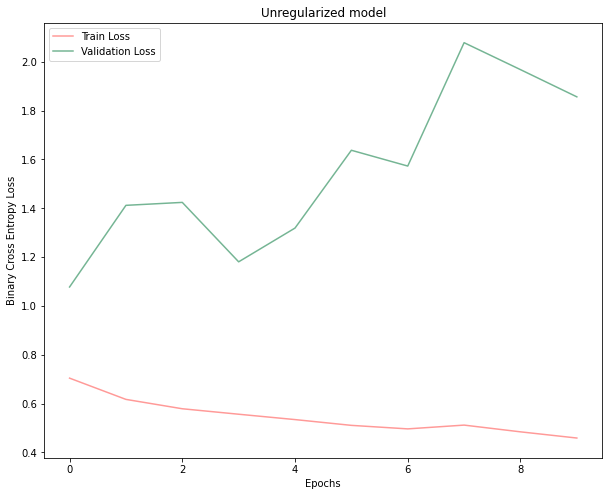

In [ ]:
# Plot the loss of the model
plt.rcParams["figure.figsize"] = (10,8)
plt.title("Unregularized model")
plt.plot(history.history['loss'], label='Train Loss', color='#FF9A98')
plt.plot(history.history['val_loss'],  label='Validation Loss', color='#75B594')
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.legend()
plt.show()

## Part 3: Now with Data Augmentation

We saw in the lecture on regularization that we can slightly alter our training data to similuate a larger dataset. This means our model is less likely to overfit as there is more it would have to memorize 'memorize').

Take a look again at the [ImageDataGenerator Documentation](https://keras.io/api/preprocessing/image/) to see what choices we have for changing our data. Are all changes appropriate here?</br>
Create a new data generator `datagen_aug` that preprocesses images with your chosen changes. Then we only need to make a new `traingen_aug` using `flow_from_directory`.

<b>Create Augmenting Generator</b>

These are just a few of the options available (for more, see the Keras documentation). 
Let’s quickly go over this code:

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half the images horizontally—relevant when there are no assumptions of - horizontal asymmetry (for example, real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift. 

Let’s look at the augmented images

In [ ]:
datagen_aug = ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.4,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

traingen_aug = datagen_aug.flow_from_directory(directory='../data/dogs-vs-cats/train',target_size=target_size,batch_size=batch_size,class_mode='binary')

Found 1244 images belonging to 2 classes.


Let’s look at the output of one of this generator. Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point if using a `for` loop. Better still, you can use the built in `next` function to return a signle element from the generator.

Run the below cell several times to see that different images are generated every time!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


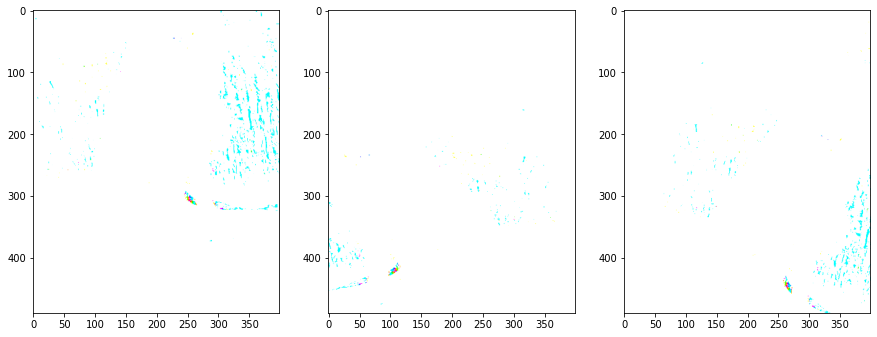

In [ ]:
img = image.load_img('/data/dogs-vs-cats/train/dogs/dog.10014.jpg')
img = image.img_to_array(img)
img = np.array([img])
aug_iter = datagen_aug.flow(img, batch_size=1)
fig, ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
  img_aug= next(aug_iter)[0]
  ax[i].imshow(img_aug)

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. 

<b>2nd CNN Model</b>

To see the affect of data augmentation you should use the same architecture as your first model and the same validation data 'valgen' and test data 'testgen'.

In [ ]:
base_model=keras.applications.MobileNetV2(input_shape=[96,96,3],include_top=False,weights='imagenet')
base_model.trainable=False
avg=keras.layers.GlobalAveragePooling2D()
layer=keras.layers.Dense(128,activation='relu')
output=keras.layers.Dense(1,activation='sigmoid')
new_model=tf.keras.Sequential([base_model,avg,layer,output])
new_model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=1e-3),metrics=['accuracy'])

<b> Fit Model </b>

In [ ]:
new_history=new_model.fit(traingen_aug,validation_data=valgen,steps_per_epoch=1244//16,validation_steps=656//16,epochs=10)

Epoch 1/10
77/77 [==============================] - 10s 127ms/step - loss: 0.7141 - accuracy: 0.5904 - val_loss: 0.7743 - val_accuracy: 0.5610
Epoch 2/10
77/77 [==============================] - 9s 116ms/step - loss: 0.6763 - accuracy: 0.5953 - val_loss: 0.7211 - val_accuracy: 0.6235
Epoch 3/10
77/77 [==============================] - 9s 117ms/step - loss: 0.6368 - accuracy: 0.6279 - val_loss: 0.7219 - val_accuracy: 0.6189
Epoch 4/10
77/77 [==============================] - 9s 118ms/step - loss: 0.6589 - accuracy: 0.5920 - val_loss: 1.2778 - val_accuracy: 0.5442
Epoch 5/10
77/77 [==============================] - 9s 119ms/step - loss: 0.6331 - accuracy: 0.6262 - val_loss: 0.7665 - val_accuracy: 0.6189
Epoch 6/10
77/77 [==============================] - 9s 117ms/step - loss: 0.6305 - accuracy: 0.6515 - val_loss: 0.9538 - val_accuracy: 0.5564
Epoch 7/10
77/77 [==============================] - 9s 117ms/step - loss: 0.6238 - accuracy: 0.6653 - val_loss: 0.8729 - val_accuracy: 0.5899
Epoch

<b>Plot the Training History</b>

Plot the training and validation accuracy and loss.

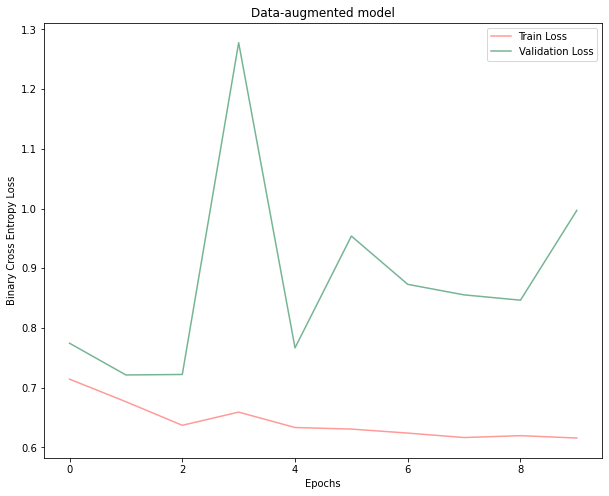

In [ ]:
# Plot the loss of the model
plt.rcParams["figure.figsize"] = (10,8)
plt.title("Data-augmented model")
plt.plot(new_history.history['loss'], label='Train Loss', color='#FF9A98')
plt.plot(new_history.history['val_loss'],  label='Validation Loss', color='#75B594')
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.legend()
plt.show()

<b> Evaluate your model </b>

In [ ]:
new_model.evaluate(testgen)

41/41 [==============================] - 2s 49ms/step - loss: 0.9490 - accuracy: 0.5951


[0.9489529728889465, 0.5950919985771179]